In [1]:
import pykoop
import sklearn
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import seaborn as sns
from numpy.polynomial.legendre import Legendre
from scipy.special import legendre # legendre(n)用于生成n阶勒让德多项式。
# 勒让德多项式是一类正交多项式，常用于数值分析、物理问题的求解以及函数逼近。
from scipy.integrate import fixed_quad 
#fixed_quad是一种使用固定阶数的高斯求积法进行数值积分的函数。
#它对于积分光滑函数非常精确和高效。
from scipy.linalg import eig
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
# eig：用于计算一般方阵的特征值和特征向量。
# eigh：用于计算厄米特（Hermitian）矩阵或实对称矩阵的特征值和特征向量。
# eigsh：用于计算大型稀疏对称矩阵的特征值。
import warnings

In [3]:
def kuramoto_ode_cluster(theta, omega, K_matrix):
    """Kuramoto ODE with custom coupling matrix K_ij."""
    N = len(theta)
    dtheta = np.zeros(N)
    for i in range(N):
        dtheta[i] = omega[i] + np.sum(
            K_matrix[i, :] * np.sin(theta - theta[i])
        ) / N
    return dtheta

def generate_kuramoto_cluster_data_sin_cos(
    N=12, n_clusters=3, K_intra=2.0, K_inter=0.2,
    dt=0.01, T=30, noise=0.0, random_state=0):
    """
    生成带‘团结构’的Kuramoto振子数据。
    团内耦合K_intra > 团间耦合K_inter。
    """
    np.random.seed(random_state)
    t_steps = int(T / dt)
    t = np.arange(0, T, dt)
    omega = 2 * np.pi * (0.2 + 0.05 * np.random.randn(N))
    theta = np.random.uniform(0, 2 * np.pi, N)

    # --- 构造耦合矩阵 ---
    cluster_size = N // n_clusters
    K_matrix = np.full((N, N), K_inter)
    for c in range(n_clusters):
        start = c * cluster_size
        end = N if c == n_clusters - 1 else (c + 1) * cluster_size
        K_matrix[start:end, start:end] = K_intra

    # --- 时间积分 ---
    theta_hist = np.zeros((t_steps, N))
    theta_hist[0] = theta
    for i in range(1, t_steps):
        dtheta = kuramoto_ode_cluster(theta, omega, K_matrix)
        theta = np.mod(theta + dtheta * dt, 2 * np.pi)
        if noise > 0:
            theta += noise * np.random.randn(N)
        theta_hist[i] = theta

    X = np.hstack([np.cos(theta_hist), np.sin(theta_hist)])  # sin-cos embedding
    return X, theta_hist, t, K_matrix

def compute_order_parameter(theta):
    return np.abs(np.mean(np.exp(1j * theta), axis=1))

def compute_cluster_order_parameters(theta, n_clusters):
    """计算每个团的序参量"""
    N = theta.shape[1]
    cluster_size = N // n_clusters
    group_r = []
    for c in range(n_clusters):
        start = c * cluster_size
        end = N if c == n_clusters - 1 else (c + 1) * cluster_size
        r_c = compute_order_parameter(theta[:, start:end])
        group_r.append(r_c)
    return group_r

def plot_clustered_kuramoto(N=12, n_clusters=3, K_intra=2.0, K_inter=0.2, noise=0.0, T=30, dt=0.01):
    X_embed, theta_hist, t, K_matrix = generate_kuramoto_cluster_data_sin_cos(
        N=N, n_clusters=n_clusters, K_intra=K_intra, K_inter=K_inter, dt=dt, T=T, noise=noise
    )

    r_total = compute_order_parameter(theta_hist)
    r_groups = compute_cluster_order_parameters(theta_hist, n_clusters)

    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    colors = plt.cm.tab10(np.arange(n_clusters))
    N_cluster = N // n_clusters

    # (2) 每个振子的相位随时间
    ax2 = axes[0]
    for g in range(n_clusters):
        for i in range(g * N_cluster, (g + 1) * N_cluster):
            ax2.plot(t, X_embed[:, i], lw=0.8, color=colors[g])
    ax2.set_title("Phase Evolution θ_i(t)")
    ax2.set_xlabel("Time")

    # (3) 各团与总体序参量
    ax3 = axes[1]
    ax3.plot(t, r_total, "k", lw=2, label="Overall r(t)")
    for g, r_c in enumerate(r_groups):
        ax3.plot(t, r_c, lw=2, color=colors[g], label=f"Group {g+1}")
    ax3.set_ylim(0, 1.05)
    ax3.set_title("Order parameters")
    ax3.legend()
    ax3.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
    return X_embed, K_matrix


In [29]:
def compute_koopman_matrices(XH, W, YH):
    """
    Parameters:
    XH+YH
    Returns:
    G: Gram矩阵<psi_j, psi_i>
    A: 第一个Galerkin矩阵 <K psi_j, psi_i>
    L: 第二个Galerkin矩阵 <K psi_j, K psi_i>
    """
    M = XH.shape[0] # 数据点数量
    N = XH.shape[1]  # 基函数数量
    
    # 初始化矩阵
    G = np.zeros((N, N))
    A = np.zeros((N, N))
    L = np.zeros((N, N))
    
    # 计算矩阵元素
    for j in range(M):
        G += np.outer(XH[j, :] * W[j], XH[j, :])
        A += np.outer(XH[j, :] * W[j], YH[j, :])
        L += np.outer(YH[j, :] * W[j], YH[j, :])
    
    return G, A, L

def compute_edmd_eigenpairs(G, A, L):
    """
    根据算法2步骤2，求解广义特征值问题 A g = λ G g
    返回特征值和对应的特征向量（系数向量）

    Parameters:
    G: Gram矩阵 Ψ_X^* W Ψ_X
    A: 矩阵 Ψ_X^* W Ψ_Y
    L: 矩阵 Ψ_Y^* W Ψ_Y

    Returns:
    eigenvalues: 特征值数组
    eigenvectors: 特征向量矩阵，每一列是一个特征向量 g
    """
    eigenvalues, eigenvectors = eig(A, G)
    return eigenvalues, eigenvectors

def compute_residual(lambda_val, g, G, A, L):
    """
    根据公式(4.6)计算给定特征对(λ, g)的残差

    Parameters:
    lambda_val: 特征值 λ
    g: 特征向量（系数向量）
    G, A, L: ResDMD矩阵

    Returns:
    res: 残差值
    """
    g = g.reshape(-1, 1) # 确保是列向量
    gH = g.T.conj() # 行向量，g的共轭转置

    # 计算分子: g^* (L - λ A^H - \bar{λ} A + |λ|^2 G) g
    numerator_matrix = L - lambda_val * A.T.conj() - np.conj(lambda_val) * A + (np.abs(lambda_val)**2) * G
    numerator = (gH @ numerator_matrix @ g).item()
    numerator = np.real(numerator) # 确保是实数

    # 计算分母: g^* G g
    denominator = (gH @ G @ g).item()
    denominator = np.real(denominator)

    # 避免除零，计算残差
    if denominator <= 0:
        return np.inf
    else:
        res_squared = numerator / denominator
        # 由于数值误差，结果可能为负，取绝对值再开方
        return np.sqrt(np.abs(res_squared))
    
def koop_pseudo_spec(G, A, L, z_pts, **kwargs):
    """
    计算K的伪谱
    
    Parameters:
    G: Gram矩阵<psi_j, psi_i>
    A: 第一个Galerkin矩阵 <K psi_j, psi_i>
    L: 第二个Galerkin矩阵 <K psi_j, K psi_i>
    z_pts: 复数点向量，用于计算伪谱
    
    Optional:
    reg_param: G的正则化参数
    
    Returns:
    RES: z_pts处的残差
    """
    # 解析可选参数
    reg_param = kwargs.get('reg_param', 1e-14)
    
    # 确保矩阵是Hermitian的
    G = (G + G.T.conj()) / 2
    L = (L + L.T.conj()) / 2
    
    # 正则化G并计算SQ矩阵
    G_reg = G + np.linalg.norm(G) * reg_param * np.eye(G.shape[0])
    w, V = eigh(G_reg)
    
    # 避免除零和负值
    w = np.maximum(w, 1e-15)
    w_sqrt = np.sqrt(1.0 / np.abs(w))
    SQ = V @ np.diag(w_sqrt) @ V.T.conj()
    
    z_pts = z_pts.flatten()
    LL = len(z_pts)
    RES = np.zeros(LL, dtype=float)
    
    if LL > 0:
        warnings.filterwarnings('ignore', category=UserWarning)
        
        for jj in range(LL):
            z = z_pts[jj]
            try:
                # 构造该z对应的矩阵
                M_z = (L - z * A.T.conj() - np.conj(z) * A + (np.abs(z)**2) * G)
                M_transformed = SQ @ M_z @ SQ
                
                # 确保矩阵是Hermitian的以用于eigvalsh
                M_transformed = (M_transformed + M_transformed.T.conj()) / 2
                
                # 使用稠密计算找到最小特征值（更稳定）
                eigvals = np.linalg.eigvalsh(M_transformed)
                min_eigval = np.min(np.real(eigvals))
                
                # 避免由于数值误差导致的负值
                RES[jj] = np.sqrt(max(0, min_eigval))
                
            except Exception as e:
                print(f"Warning: Error at z={z}: {e}")
                RES[jj] = np.nan
    
    warnings.resetwarnings()
    
    return RES

def plot_pseudospectra(G, A, L, step=0.05, residual_threshold=0.01, padding_ratio=0.2, fixed_range=None):
    """
    绘制伪谱图，并根据残差阈值区分可靠和虚假特征值

    Parameters:
    G, A, L: Koopman矩阵
    x_range, y_range: 绘图范围
    step: 网格步长
    residual_threshold: 算法2中的残差阈值ε
    padding_ratio: 在特征值范围基础上添加的边距比例
    fixed_range: 如果提供，则使用固定的绘图范围 (x_min, x_max, y_min, y_max)
    """
    # 1. 计算EDMD特征对 (算法2步骤2)
    eigenvalues, eigenvectors = compute_edmd_eigenpairs(G, A, L)
    # 特征向量在矩阵eigenvectors的列中

    # 2. 为每个特征对计算残差 (算法2步骤3的逻辑)
    residuals = []
    reliable_indices = []
    spurious_indices = []

    for i in range(len(eigenvalues)):
        lambda_i = eigenvalues[i]
        g_i = eigenvectors[:, i]
        res_i = compute_residual(lambda_i, g_i, G, A, L)
        residuals.append(res_i)

        if res_i <= residual_threshold:
            reliable_indices.append(i)
        else:
            spurious_indices.append(i)

    print(f"总特征值数量: {len(eigenvalues)}")
    print(f"res阈值: {residual_threshold}")
    print(f"可靠特征值数量 (res <= {residual_threshold}): {len(reliable_indices),reliable_indices}")
    print(f"虚假特征值数量 (res > {residual_threshold}): {len(spurious_indices)}")

    # 3. 确定绘图范围
    if fixed_range is not None:
        # 使用固定的绘图范围
        x_range = (fixed_range[0], fixed_range[1])
        y_range = (fixed_range[2], fixed_range[3])
    else:
        # 自适应范围：基于所有特征值的分布
        real_parts = np.real(eigenvalues)
        imag_parts = np.imag(eigenvalues)
        
        # 计算特征值的范围
        real_min, real_max = np.min(real_parts), np.max(real_parts)
        imag_min, imag_max = np.min(imag_parts), np.max(imag_parts)
        
        # 使用相同的范围，保持纵横比一致
        overall_min = min(real_min, imag_min)
        overall_max = max(real_max, imag_max)
        overall_range = overall_max - overall_min
        
        # 如果范围太小（如所有特征值都集中在一点），设置最小范围
        if overall_range < 0.1:
            overall_range = 1.0
            center = (overall_min + overall_max) / 2
            overall_min = center - 0.5
            overall_max = center + 0.5
        
        # 添加边距
        padding = overall_range * padding_ratio
        x_range = (overall_min - padding, overall_max + padding)
        y_range = (overall_min - padding, overall_max + padding)
    
    # 3. 计算伪谱网格（算法3/原有伪谱计算逻辑）
    x_pts = np.arange(x_range[0], x_range[1] + step, step)
    y_pts = np.arange(y_range[0], y_range[1] + step, step)
    X_grid, Y_grid = np.meshgrid(x_pts, y_pts)
    z_pts = X_grid + 1j * Y_grid
    z_flat = z_pts.flatten()

    RES = koop_pseudo_spec(G, A, L, z_flat)
    RES = RES.reshape(z_pts.shape)
    RES = np.nan_to_num(RES, nan=np.max(RES[~np.isnan(RES)]))
    # 计算完RES并reshape后，添加这行
    print(f"残差RES的范围：{np.min(RES):.6f} ~ {np.max(RES):.6f}")

    # 4. 绘图
    plt.figure(figsize=(8, 8))

    # 伪谱等高线
    #levels = [0.001, 0.01, 0.1, 0.3]
    levels = [0.001, 0.01, 0.1]
    contour = plt.contour(X_grid, Y_grid, np.real(RES), levels=levels,
                         colors='black', linewidths=2)
    plt.clabel(contour, inline=True, fontsize=11, fmt='%.3f')

    # 绘制特征值
    # 可靠特征值 (残差小) - 蓝色十字
    reliable_eigs = eigenvalues[reliable_indices]
    plt.plot(np.real(reliable_eigs), np.imag(reliable_eigs), 'x',
             markersize=8, color='blue', markeredgewidth=2,
             label=f'Reliable eigenvalues (res $\leq$ {residual_threshold})')

    # 虚假特征值 (残差大) - 洋红点
    spurious_eigs = eigenvalues[spurious_indices]
    plt.plot(np.real(spurious_eigs), np.imag(spurious_eigs), '.',
             markersize=10, color='magenta',
             label='Spurious eigenvalues')

    # 格式化
    plt.gca().set_aspect('equal')
    plt.xlabel('Real', fontsize=14)
    plt.ylabel('Imaginary', fontsize=14)
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.grid(True, alpha=0.3)
    #plt.legend(fontsize=12, loc='upper right', frameon=True, fancybox=True, shadow=True)
    plt.legend(fontsize=12)
    plt.title(f'Reliable num={len(reliable_indices)}, Residual Threshold={residual_threshold}', fontsize=14)
    plt.tight_layout()
    plt.show()
    return eigenvalues, residuals, reliable_indices

<>:235: DeprecationWarning: invalid escape sequence '\l'
<>:235: DeprecationWarning: invalid escape sequence '\l'
/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_236/2843276328.py:235: DeprecationWarning: invalid escape sequence '\l'
  label=f'Reliable eigenvalues (res $\leq$ {residual_threshold})')


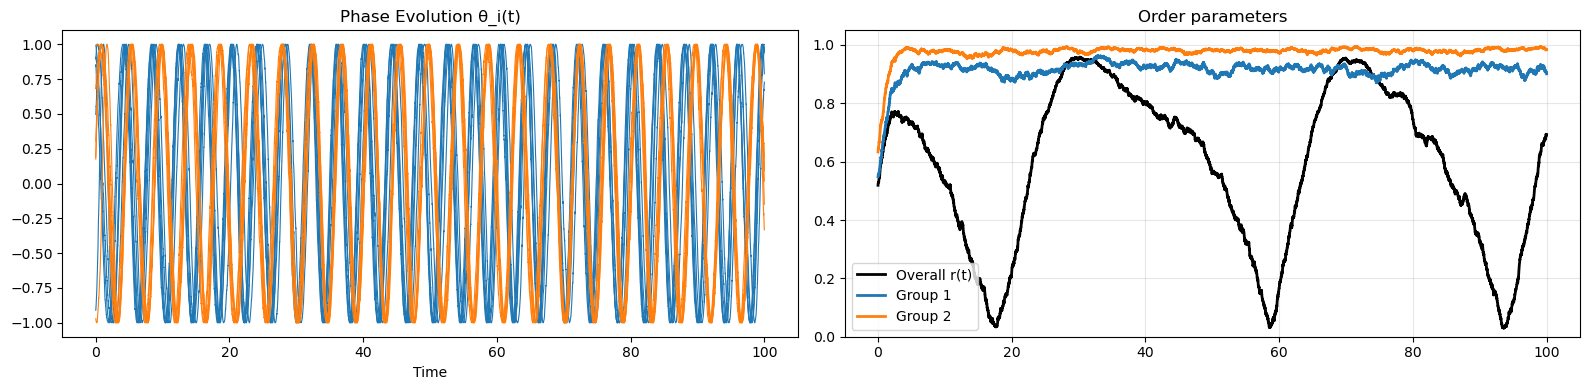

In [50]:
# ▶ 运行示例
X_embed, K_matrix = plot_clustered_kuramoto(
    N=12,          
    n_clusters=2,  
    K_intra=2,   
    K_inter=0.1,   
    noise=0.01,
    T=100
)

In [51]:
kp = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
        ('pl', pykoop.PolynomialLiftingFn(order=1,interaction_only=True)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=0.5),
    #regressor=pykoop.Dmd(tsvd=pykoop.Tsvd(truncation='rank',truncation_param=4)),
)
# Fit the pipeline
kp.fit(
    X_embed,
    n_inputs=0
)
error = -kp.score(X_embed)
error


np.float64(0.08016150077988075)

In [15]:
# 径向基函数
kp = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
        ('rbf', pykoop.RbfLiftingFn(rbf='gaussian',centers=pykoop.ClusterCenters(estimator=sklearn.cluster.KMeans(n_clusters=24)),shape=1)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=0.5),
)
# Fit the pipeline
kp.fit(
    X_embed,
    n_inputs=0
)
error = -kp.score(X_embed)
error

np.float64(0.023906744170413843)

In [19]:
#kernal，随机傅立叶表征
kp = pykoop.KoopmanPipeline(
    lifting_functions=[(
        'rff',
        pykoop.KernelApproxLiftingFn(
            kernel_approx=pykoop.RandomFourierKernelApprox(
                n_components=100,
                random_state=0,
            )),
    )],
    regressor=pykoop.Edmd(),
)

kp.fit(
    X_embed,
    n_inputs=0
)
error = -kp.score(X_embed)
error

np.float64(0.04927083670256271)

In [22]:
#延迟嵌入，Hankel
kp = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
        ('delay', pykoop.DelayLiftingFn(n_delays_state=2)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=0.5),
    #regressor=pykoop.Dmd(tsvd=pykoop.Tsvd(truncation='unknown_noise')),
    #regressor=pykoop.Dmd(tsvd=pykoop.Tsvd(truncation='rank',truncation_param=4)),
)
# Fit the pipeline
kp.fit(
    X_embed,
    n_inputs=0
)
error = -kp.score(X_embed)
error

np.float64(0.08357105909849975)

总特征值数量: 24
res阈值: 0.01
可靠特征值数量 (res <= 0.01): (4, [0, 1, 2, 3])
虚假特征值数量 (res > 0.01): 20
残差RES的范围：0.014652 ~ 0.240912


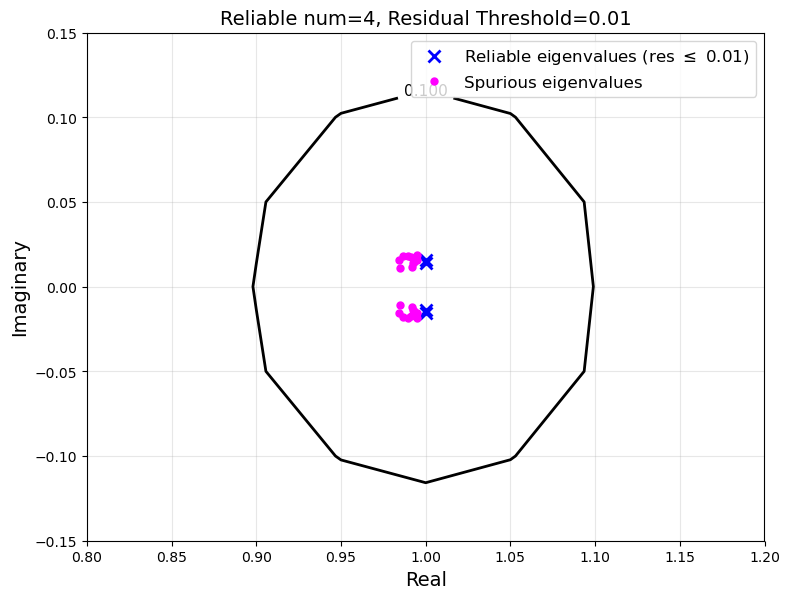

In [52]:
M = len(X_embed)-1
W = np.ones(M) / M
X = X_embed[:-1]
Y = X_embed[1:]
XH = kp.transform(X)
YH = kp.transform(Y)
G, A, L = compute_koopman_matrices(XH, W, YH)
eigenvalues, residuals, reliable_indices = plot_pseudospectra(G, A, L, residual_threshold=0.01,fixed_range=(0.8,1.20,-0.15,0.15))

In [55]:
print(eigenvalues)
print(residuals)

[0.99988962+0.01579086j 0.99988962-0.01579086j 0.9999187 +0.01411023j
 0.9999187 -0.01411023j 0.98611445+0.0232655j  0.98611445-0.0232655j
 0.96615838+0.01480294j 0.96615838-0.01480294j 0.97098057+0.01957951j
 0.97098057-0.01957951j 0.97031494+0.00871418j 0.97031494-0.00871418j
 0.97339263+0.01894907j 0.97339263-0.01894907j 0.97654919+0.0180596j
 0.97654919-0.0180596j  0.97871684+0.0148862j  0.97871684-0.0148862j
 0.97700904+0.01171545j 0.97700904-0.01171545j 0.97514213+0.01333648j
 0.97514213-0.01333648j 0.97592392+0.01563374j 0.97592392-0.01563374j]
[0.004828733517890222, 0.004828733517890577, 0.004665688619715933, 0.004665688619693343, 0.06538469502580879, 0.0653846950258271, 0.24173701449006846, 0.2417370144900633, 0.23388109024566817, 0.2338810902456655, 0.22597856355319448, 0.22597856355322718, 0.19940377356262834, 0.19940377356258798, 0.2094856832555156, 0.2094856832555156, 0.20117647848752948, 0.2011764784874975, 0.18077687682948315, 0.18077687682946053, 0.20122031897455275, 0.

In [35]:
print(eigenvalues)
print(residuals)

[0.99988962+0.01579086j 0.99988962-0.01579086j 0.9999187 +0.01411023j
 0.9999187 -0.01411023j 0.98611445+0.0232655j  0.98611445-0.0232655j
 0.96615838+0.01480294j 0.96615838-0.01480294j 0.97098057+0.01957951j
 0.97098057-0.01957951j 0.97031494+0.00871418j 0.97031494-0.00871418j
 0.97339263+0.01894907j 0.97339263-0.01894907j 0.97654919+0.0180596j
 0.97654919-0.0180596j  0.97871684+0.0148862j  0.97871684-0.0148862j
 0.97700904+0.01171545j 0.97700904-0.01171545j 0.97514213+0.01333648j
 0.97514213-0.01333648j 0.97592392+0.01563374j 0.97592392-0.01563374j]
[0.004828733517890222, 0.004828733517890577, 0.004665688619715933, 0.004665688619693343, 0.06538469502580879, 0.0653846950258271, 0.24173701449006846, 0.2417370144900633, 0.23388109024566817, 0.2338810902456655, 0.22597856355319448, 0.22597856355322718, 0.19940377356262834, 0.19940377356258798, 0.2094856832555156, 0.2094856832555156, 0.20117647848752948, 0.2011764784874975, 0.18077687682948315, 0.18077687682946053, 0.20122031897455275, 0.

In [41]:
# 紧凑打印（数组形式）
print("特征值 (保留3位小数)：", np.round(eigenvalues, 3))
print("残差 (保留3位小数)：", np.round(residuals, 3))

特征值 (保留3位小数)： [1.   +0.016j 1.   -0.016j 1.   +0.014j 1.   -0.014j 0.986+0.023j
 0.986-0.023j 0.966+0.015j 0.966-0.015j 0.971+0.02j  0.971-0.02j
 0.97 +0.009j 0.97 -0.009j 0.973+0.019j 0.973-0.019j 0.977+0.018j
 0.977-0.018j 0.979+0.015j 0.979-0.015j 0.977+0.012j 0.977-0.012j
 0.975+0.013j 0.975-0.013j 0.976+0.016j 0.976-0.016j]
残差 (保留3位小数)： [0.005 0.005 0.005 0.005 0.065 0.065 0.242 0.242 0.234 0.234 0.226 0.226
 0.199 0.199 0.209 0.209 0.201 0.201 0.181 0.181 0.201 0.201 0.178 0.178]


(<Figure size 640x480 with 2 Axes>, <Axes: >)

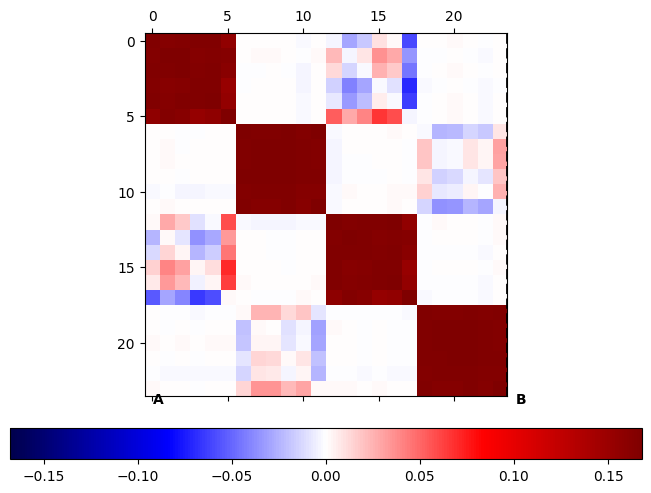

In [36]:
kp.regressor_.plot_koopman_matrix()

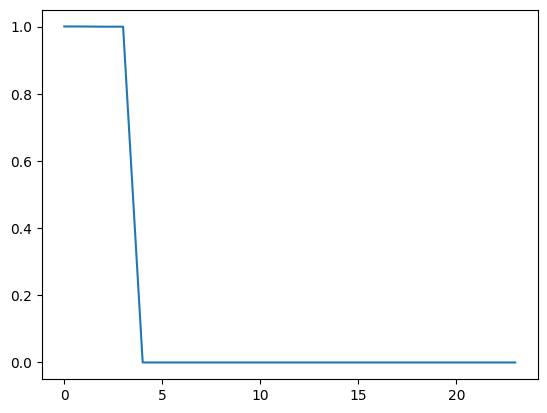

In [38]:
KM = kp.regressor_.coef_
U,S,V = np.linalg.svd(KM)
plt.figure()
plt.plot(S)
plt.show()

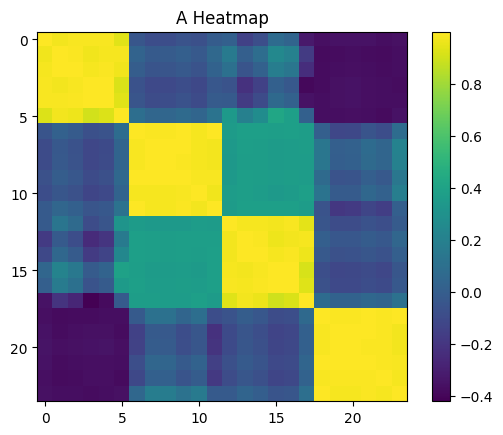

In [37]:
plt.imshow(A, cmap='viridis')  # imshow是热力图核心函数，cmap指定配色（可换）
plt.colorbar()  # 显示颜色条（直观查看数值对应关系）
plt.title('A Heatmap')  # 可选：添加标题
plt.show()  # 显示图片

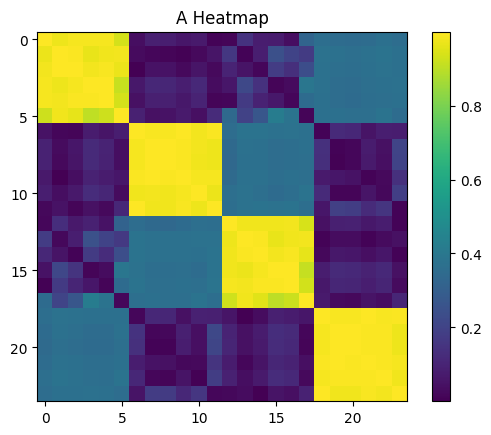

In [40]:
plt.imshow(np.abs(A), cmap='viridis')  # imshow是热力图核心函数，cmap指定配色（可换）
plt.colorbar()  # 显示颜色条（直观查看数值对应关系）
plt.title('A Heatmap')  # 可选：添加标题
plt.show()  # 显示图片

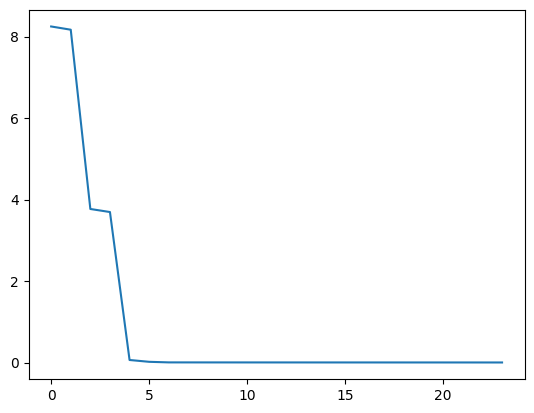

In [39]:
UA,SA,VA = np.linalg.svd(A)
plt.figure()
plt.plot(SA)
plt.show()